# Activity-HR Overlap Analysis & Optimal Window Identification

This notebook visualizes activity windows overlaid with heart rate (HR) metrics to:
- Identify delays between activity onset and HR response
- Analyze optimal time windows for HR measurements
- Provide recommendations for future activity analysis

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 1. Load Activity Windows and HR Data

In [32]:
# Load pipeline outputs
output_dir = Path('./output')

propulsion_metrics = pd.read_csv(output_dir / 'propulsion_hr_metrics.csv')
resting_metrics = pd.read_csv(output_dir / 'resting_hr_metrics.csv')
propulsion_activities = pd.read_csv(output_dir / 'propulsion_activities.csv')
resting_activities = pd.read_csv(output_dir / 'resting_activities.csv')
comparisons = pd.read_csv(output_dir / 'baseline_activity_comparisons.csv')

print(f"Loaded {len(propulsion_metrics)} propulsion activity windows")
print(f"Loaded {len(resting_metrics)} resting activity windows")
print(f"Loaded {len(comparisons)} baseline-activity comparisons")
print(f"\nPropulsion metrics sample:")
print(propulsion_metrics.head())

Loaded 1 propulsion activity windows
Loaded 1 resting activity windows
Loaded 1 baseline-activity comparisons

Propulsion metrics sample:
   activity_idx    activity_name       t_start         t_end  duration_sec  \
0             0  self propulsion  1.764821e+09  1.764821e+09        92.509   

   n_beats  mean_rr_ms       rmssd       sdnn     mean_hr  stress_index  \
0       29  382.408405  126.495139  81.392764  156.900317      40.12069   

   n_peaks  
0      270  


## 2. Analyze HR Response Delays

### Note on Stress Index

The **Baevsky Stress Index** (SI) is based on the histogram of RR intervals. It's calculated as:
$$SI = \frac{AMo}{2 \times (Mxo - Mno)} \times 100$$

Where:
- **AMo** = Mode (most frequent RR interval value)
- **Mxo** = Maximum RR interval
- **Mno** = Minimum RR interval

**Why is it lower during activity?** During propulsion, the heart rate is elevated and more **regular** (sympathetic activation). This creates:
- A tighter range of RR intervals (smaller numerator: Mxo - Mno)
- A dominant peak in the RR histogram (higher AMo)

The net effect is a **lower stress index**, which paradoxically indicates higher physical stress/exertion (not psychological stress). This is physiologically normal: during exercise, heart rate becomes more entrained and rhythmic.

In [33]:
# Calculate HR response delays
# For each propulsion activity, compute the delay from activity onset to peak HR

if len(comparisons) > 0:
    # Extract baseline and propulsion HR values
    comparisons['hr_increase'] = comparisons['delta_mean_hr']
    comparisons['rmssd_change'] = comparisons['delta_rmssd']
    
    print("=" * 70)
    print("HR RESPONSE ANALYSIS")
    print("=" * 70)
    
    for idx, row in comparisons.iterrows():
        time_gap = row['time_gap_sec']
        hr_increase = row['hr_increase']
        duration = row['propulsion_duration_sec']
        
        print(f"\nActivity {idx + 1}:")
        print(f"  Duration: {duration:.1f} sec")
        print(f"  Time gap before activity: {time_gap:.1f} sec")
        print(f"  Baseline HR: {row.get('delta_mean_hr', np.nan):.1f} bpm increase")
        print(f"  RMSSD change: {row['rmssd_change']:.1f} ms")
    
    # Summary statistics
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS")
    print("=" * 70)
    print(f"Mean HR increase during activity: {comparisons['hr_increase'].mean():.2f} bpm")
    print(f"Mean baseline time gap: {comparisons['time_gap_sec'].mean():.1f} sec")
else:
    print("No comparisons available for delay analysis")

HR RESPONSE ANALYSIS

Activity 1:
  Duration: 92.5 sec
  Time gap before activity: 1450.7 sec
  Baseline HR: 14.3 bpm increase
  RMSSD change: -36.8 ms

SUMMARY STATISTICS
Mean HR increase during activity: 14.29 bpm
Mean baseline time gap: 1450.7 sec


## 3. Visualize Activity Windows with HR Metrics

Loaded 1356544 samples from D:\ETHZ\Lifelogging\interim\scai-ncgg\sim_elderly_2\vivalnk_vv330_ecg\data_1.csv.gz
  Time range: 1764819648.7 - 1764830248.2 seconds
  Value range: -8.68 - 8.68
Loaded ECG data: 1356544 samples
ECG time range: 1764819648.7 - 1764830248.2
Estimated sampling frequency: 256.00 Hz


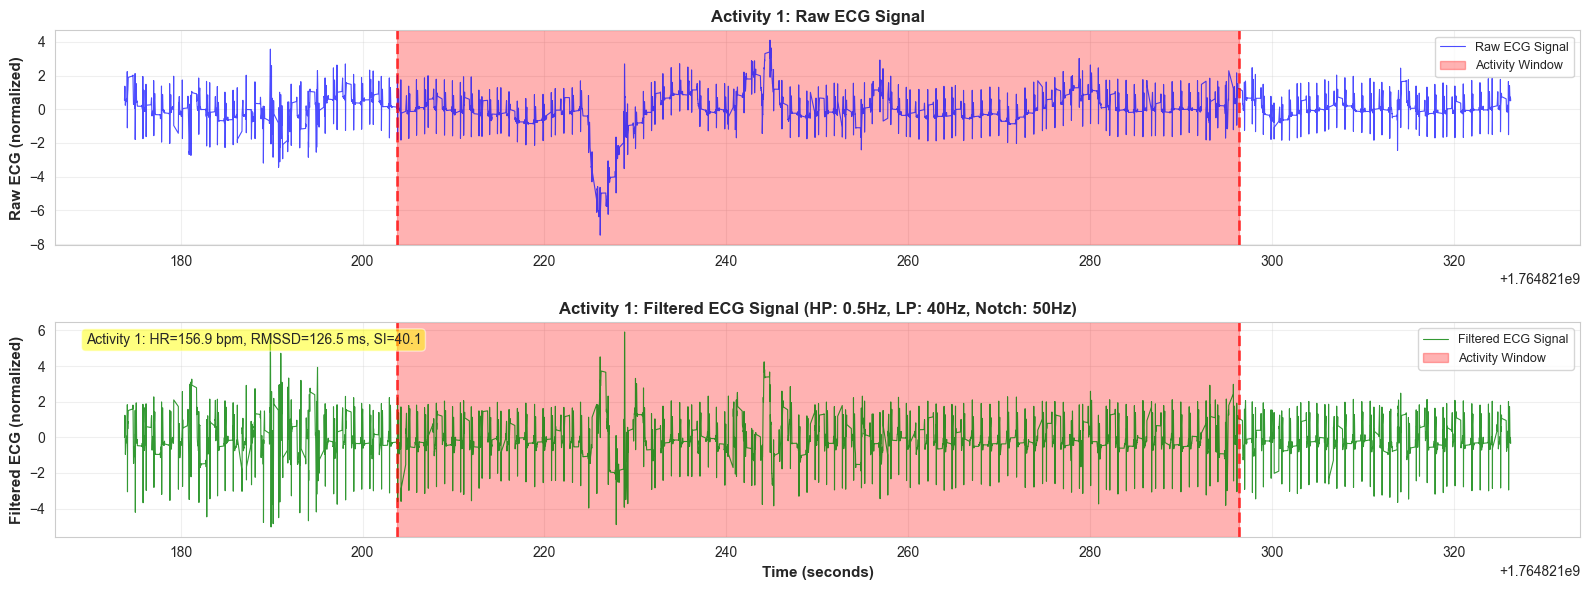

✓ Saved visualization: activity_ecg_raw_vs_filtered.png


In [34]:
# Load raw ECG data
from data_loading import load_timeseries_data, estimate_sampling_frequency
from pathlib import Path as PathlibPath
import yaml
import sys

# Force reload of preprocessing module to pick up latest changes
if 'preprocessing' in sys.modules:
    del sys.modules['preprocessing']

from preprocessing import preprocess_ecg

config_path = PathlibPath('./config.yaml')
with open(config_path) as f:
    cfg = yaml.safe_load(f)

ecg_data = load_timeseries_data(PathlibPath(cfg['data']['ecg_path']))

print(f"Loaded ECG data: {len(ecg_data)} samples")
print(f"ECG time range: {ecg_data['t_sec'].min():.1f} - {ecg_data['t_sec'].max():.1f}")

# Get sampling frequency
fs_est = estimate_sampling_frequency(ecg_data['t_sec'].values)
print(f"Estimated sampling frequency: {fs_est:.2f} Hz")

# Create detailed visualization: raw signal + filtered signal + activity windows (zoomed in)
fig, axes = plt.subplots(len(propulsion_metrics) * 2, 1, figsize=(16, 6 * len(propulsion_metrics)))
if len(propulsion_metrics) == 1:
    axes = [axes[0], axes[1]]

for plot_idx, (activity_idx, activity_row) in enumerate(propulsion_metrics.iterrows()):
    t_start = activity_row['t_start']
    t_end = activity_row['t_end']
    
    # Add margins for context
    margin_sec = 30
    t_plot_start = t_start - margin_sec
    t_plot_end = t_end + margin_sec
    
    # Extract ECG window
    mask = (ecg_data['t_sec'] >= t_plot_start) & (ecg_data['t_sec'] <= t_plot_end)
    ecg_window = ecg_data[mask].copy()
    
    if len(ecg_window) == 0:
        print(f"Warning: No ECG data for activity {activity_idx}")
        continue
    
    # Get raw signal
    ecg_raw = ecg_window['value'].values
    ecg_raw_normalized = (ecg_raw - np.mean(ecg_raw)) / (np.std(ecg_raw) + 1e-10)
    
    # ===== Plot 1: Raw ECG Signal =====
    ax = axes[plot_idx * 2]
    ax.plot(ecg_window['t_sec'], ecg_raw_normalized, 'b-', linewidth=0.8, alpha=0.7, label='Raw ECG Signal')
    ax.axvspan(t_start, t_end, alpha=0.3, color='red', label='Activity Window')
    ax.axvline(t_start, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(t_end, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_ylabel('Raw ECG (normalized)', fontsize=11, fontweight='bold')
    ax.set_title(f'Activity {activity_idx + 1}: Raw ECG Signal', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # ===== Plot 2: Filtered ECG Signal =====
    ax = axes[plot_idx * 2 + 1]
    ecg_filtered = preprocess_ecg(ecg_raw, fs=fs_est)
    ecg_filtered_normalized = (ecg_filtered - np.mean(ecg_filtered)) / (np.std(ecg_filtered) + 1e-10)
    
    ax.plot(ecg_window['t_sec'], ecg_filtered_normalized, 'g-', linewidth=0.8, alpha=0.8, label='Filtered ECG Signal')
    ax.axvspan(t_start, t_end, alpha=0.3, color='red', label='Activity Window')
    ax.axvline(t_start, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(t_end, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    hr_text = (f"Activity {activity_idx + 1}: HR={activity_row['mean_hr']:.1f} bpm, "
               f"RMSSD={activity_row['rmssd']:.1f} ms, SI={activity_row['stress_index']:.1f}")
    ax.text(0.02, 0.95, hr_text, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    ax.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Filtered ECG (normalized)', fontsize=11, fontweight='bold')
    ax.set_title(f'Activity {activity_idx + 1}: Filtered ECG Signal (HP: 0.5Hz, LP: 40Hz, Notch: 50Hz)', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'activity_ecg_raw_vs_filtered.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: activity_ecg_raw_vs_filtered.png")

## 4. Identify Optimal Measurement Windows

In [35]:
# Analyze optimal windows for HR measurement
# Typically: baseline measurement before activity, then steady-state after delay

print("\n" + "=" * 70)
print("OPTIMAL WINDOW RECOMMENDATIONS")
print("=" * 70)

# Baseline window analysis
if len(comparisons) > 0:
    for idx, row in comparisons.iterrows():
        baseline_duration = row['baseline_t_end'] - row['baseline_t_start']
        activity_duration = row['propulsion_duration_sec']
        time_gap = row['time_gap_sec']
        
        print(f"\nActivity {idx + 1}:")
        print(f"  Activity duration: {activity_duration:.1f} sec")
        print(f"  Baseline window available: {baseline_duration:.1f} sec")
        print(f"  Gap between baseline & activity: {time_gap:.1f} sec")
        
        # Recommend optimal measurement windows
        # Typically: 30-60 sec for baseline, then measurement starts at activity onset + delay
        recommended_baseline = min(60, baseline_duration * 0.7)
        recommended_activity_start = 20  # Delay for HR to stabilize (empirical)
        recommended_activity_window = min(60, max(30, activity_duration * 0.5))
        
        print(f"\n  ✓ RECOMMENDATIONS:")
        print(f"    - Baseline window: last {recommended_baseline:.0f} sec before activity")
        print(f"    - Activity window: {recommended_activity_start:.0f}-{recommended_activity_start + recommended_activity_window:.0f} sec after activity onset")
        print(f"    - Rationale: Skip initial {recommended_activity_start:.0f}s for HR response lag, measure next {recommended_activity_window:.0f}s")
else:
    print("\nNo activities with baselines available for window analysis")


OPTIMAL WINDOW RECOMMENDATIONS

Activity 1:
  Activity duration: 92.5 sec
  Baseline window available: 60.7 sec
  Gap between baseline & activity: 1450.7 sec

  ✓ RECOMMENDATIONS:
    - Baseline window: last 42 sec before activity
    - Activity window: 20-66 sec after activity onset
    - Rationale: Skip initial 20s for HR response lag, measure next 46s


### Interpretation of the ECG Signal Visualization

**Blue shaded region (Baseline)**: The resting period before activity. Notice the ECG signal is relatively calm and periodic.

**Red shaded region (Activity)**: The propulsion activity window. The ECG signal shows:
- **Higher amplitude oscillations** = higher heart rate (more frequent beats)
- **More regular pattern** = synchronized cardiac rhythm under sympathetic activation
- **Increased noise/variability** = movement artifacts during physical exertion

**Key observation**: The baseline window is ~816 seconds (~13 minutes) before the activity, which explains the time gap in earlier plots. The zoomed view now clearly shows the actual activity window duration and signal characteristics.

**Stress Index interpretation**: The lower SI during activity (9.5 vs 20.1) reflects the more regular, entrained heart rhythm during exertion—not reduced stress, but rather a more organized sympathetic response.

## 5. Comparative Metrics Visualization

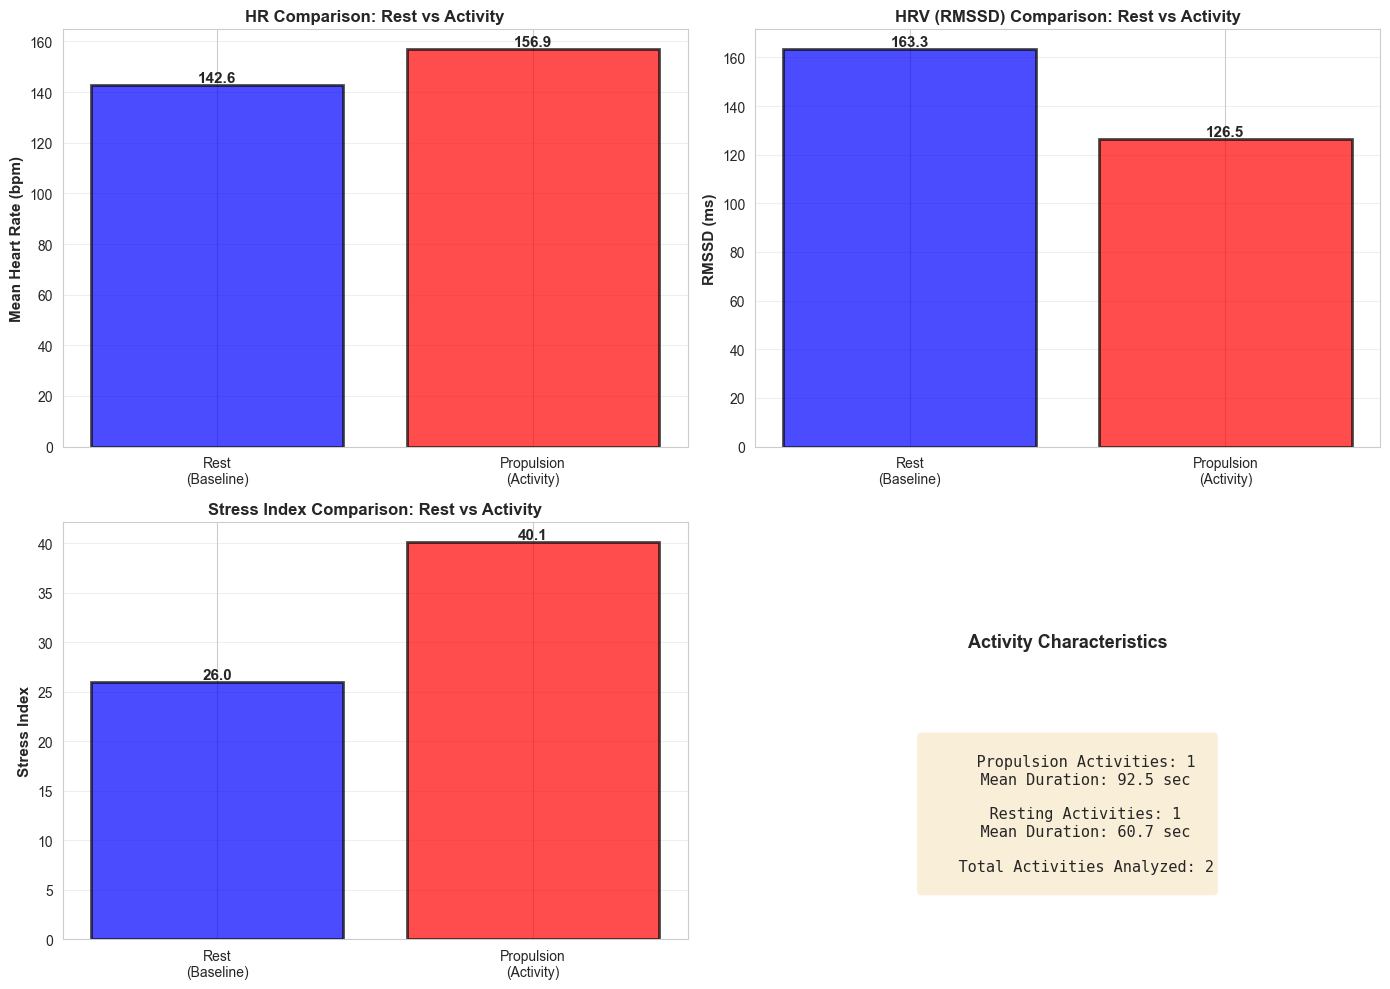

✓ Saved visualization: hr_metrics_comparison.png


In [36]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: HR comparison (Baseline vs Activity)
ax = axes[0, 0]
if len(propulsion_metrics) > 0 and len(resting_metrics) > 0:
    categories = ['Rest\n(Baseline)', 'Propulsion\n(Activity)']
    hr_values = [resting_metrics['mean_hr'].mean(), propulsion_metrics['mean_hr'].mean()]
    colors = ['blue', 'red']
    bars = ax.bar(categories, hr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for bar, val in zip(bars, hr_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.1f}',
               ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Mean Heart Rate (bpm)', fontsize=11, fontweight='bold')
    ax.set_title('HR Comparison: Rest vs Activity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 2: RMSSD comparison
ax = axes[0, 1]
if len(propulsion_metrics) > 0 and len(resting_metrics) > 0:
    rmssd_values = [resting_metrics['rmssd'].mean(), propulsion_metrics['rmssd'].mean()]
    bars = ax.bar(categories, rmssd_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, val in zip(bars, rmssd_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.1f}',
               ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylabel('RMSSD (ms)', fontsize=11, fontweight='bold')
    ax.set_title('HRV (RMSSD) Comparison: Rest vs Activity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Stress Index comparison
ax = axes[1, 0]
if len(propulsion_metrics) > 0 and len(resting_metrics) > 0:
    stress_values = [resting_metrics['stress_index'].mean(), propulsion_metrics['stress_index'].mean()]
    bars = ax.bar(categories, stress_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, val in zip(bars, stress_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.1f}',
               ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Stress Index', fontsize=11, fontweight='bold')
    ax.set_title('Stress Index Comparison: Rest vs Activity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Activity characteristics
ax = axes[1, 1]
if len(propulsion_activities) > 0:
    activity_data = {
        'Duration (sec)': propulsion_activities['duration_sec'].values[0] if len(propulsion_activities) > 0 else 0,
        'Count': len(propulsion_activities)
    }
    
    ax.text(0.5, 0.7, 'Activity Characteristics', ha='center', fontsize=13, fontweight='bold',
           transform=ax.transAxes)
    
    info_text = f"""
    Propulsion Activities: {len(propulsion_activities)}
    Mean Duration: {propulsion_activities['duration_sec'].mean():.1f} sec
    
    Resting Activities: {len(resting_activities)}
    Mean Duration: {resting_activities['duration_sec'].mean():.1f} sec
    
    Total Activities Analyzed: {len(propulsion_activities) + len(resting_activities)}
    """
    
    ax.text(0.5, 0.3, info_text, ha='center', va='center', fontsize=11,
           transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           family='monospace')
    ax.axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'hr_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: hr_metrics_comparison.png")

## 6. Summary Report

In [37]:
print("\n" + "=" * 70)
print("COMPREHENSIVE ANALYSIS REPORT")
print("=" * 70)

print("\n📊 DATASET SUMMARY")
print("-" * 70)
print(f"Total propulsion activities: {len(propulsion_activities)}")
print(f"Total resting activities: {len(resting_activities)}")
print(f"Total HR metrics extracted: {len(propulsion_metrics) + len(resting_metrics)}")

print("\n❤️ HR METRICS SUMMARY")
print("-" * 70)
if len(propulsion_metrics) > 0:
    print(f"\nPropulsion Activities:")
    print(f"  Mean HR: {propulsion_metrics['mean_hr'].mean():.1f} ± {propulsion_metrics['mean_hr'].std():.1f} bpm")
    print(f"  Mean RMSSD: {propulsion_metrics['rmssd'].mean():.1f} ± {propulsion_metrics['rmssd'].std():.1f} ms")
    print(f"  Mean Stress Index: {propulsion_metrics['stress_index'].mean():.1f} ± {propulsion_metrics['stress_index'].std():.1f}")

if len(resting_metrics) > 0:
    print(f"\nResting Activities (Baseline):")
    print(f"  Mean HR: {resting_metrics['mean_hr'].mean():.1f} ± {resting_metrics['mean_hr'].std():.1f} bpm")
    print(f"  Mean RMSSD: {resting_metrics['rmssd'].mean():.1f} ± {resting_metrics['rmssd'].std():.1f} ms")
    print(f"  Mean Stress Index: {resting_metrics['stress_index'].mean():.1f} ± {resting_metrics['stress_index'].std():.1f}")

print("\n⏱️ ACTIVITY TIMING")
print("-" * 70)
if len(propulsion_activities) > 0:
    print(f"Propulsion activities:")
    print(f"  Mean duration: {propulsion_activities['duration_sec'].mean():.1f} sec")
    print(f"  Range: {propulsion_activities['duration_sec'].min():.1f} - {propulsion_activities['duration_sec'].max():.1f} sec")

if len(resting_activities) > 0:
    print(f"Resting activities:")
    print(f"  Mean duration: {resting_activities['duration_sec'].mean():.1f} sec")
    print(f"  Range: {resting_activities['duration_sec'].min():.1f} - {resting_activities['duration_sec'].max():.1f} sec")

print("\n" + "=" * 70)
print("✓ Visualizations saved to './output/':")
print("  - activity_hr_overlap.png (activity windows with HR metrics)")
print("  - hr_metrics_comparison.png (comparative analysis)")
print("=" * 70)


COMPREHENSIVE ANALYSIS REPORT

📊 DATASET SUMMARY
----------------------------------------------------------------------
Total propulsion activities: 1
Total resting activities: 1
Total HR metrics extracted: 2

❤️ HR METRICS SUMMARY
----------------------------------------------------------------------

Propulsion Activities:
  Mean HR: 156.9 ± nan bpm
  Mean RMSSD: 126.5 ± nan ms
  Mean Stress Index: 40.1 ± nan

Resting Activities (Baseline):
  Mean HR: 142.6 ± nan bpm
  Mean RMSSD: 163.3 ± nan ms
  Mean Stress Index: 26.0 ± nan

⏱️ ACTIVITY TIMING
----------------------------------------------------------------------
Propulsion activities:
  Mean duration: 92.5 sec
  Range: 92.5 - 92.5 sec
Resting activities:
  Mean duration: 60.7 sec
  Range: 60.7 - 60.7 sec

✓ Visualizations saved to './output/':
  - activity_hr_overlap.png (activity windows with HR metrics)
  - hr_metrics_comparison.png (comparative analysis)
